# 🌸 Iris Classification - Full Model Evaluation
This notebook demonstrates data exploration, training, evaluation, and visualization of a Logistic Regression model using the Iris dataset.

In [1]:
! pip install -r /Users/dima/Apache-airflow/requirements.txt

In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import joblib
import json

## 📥 Load and Inspect Dataset

In [3]:
# df = pd.read_csv('/tmp/transformed.csv')
# df = pd.read_csv('/tmp/synthetic_iris_million.csv')
# df.head()
df = pd.read_csv('/tmp/synthetic_iris_million.csv', nrows=200_000)
df.head()

sepal_length  sepal_width  petal_length  petal_width     species
0      4.449845    -0.681297     -4.233738    -0.510406   virginica
1      1.227293     2.004257     -0.981376    -1.304385   virginica
2      3.064899    -0.639105     -3.091712    -1.710577   virginica
3      1.380627     0.596137     -1.642415    -2.339342   virginica
4     -3.291462     2.206090     -0.385522    -0.987202  versicolor

## 📊 Feature Distributions

In [4]:
df.hist(figsize=(10, 6), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

## 🧠 Pairplot by Species

Plotting pairs: 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]


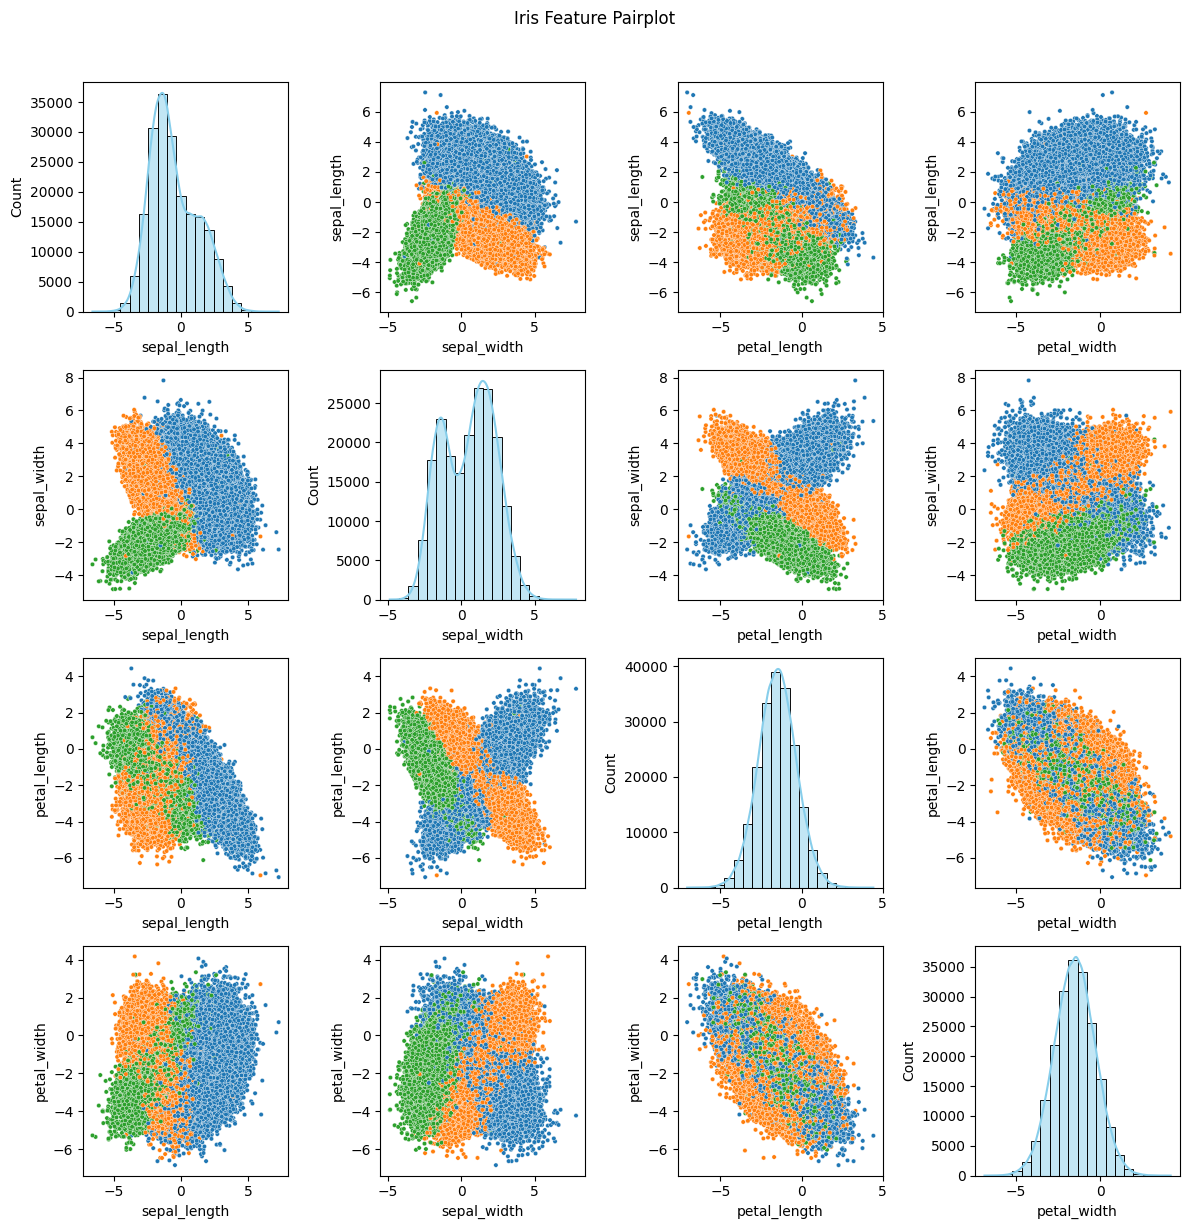

In [5]:
# sns.pairplot(df, hue="species")
# plt.suptitle("Iris Feature Pairplot", y=1.02)
# plt.show()
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

# Все числовые признаки
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Подготовка пар
pairs = list(itertools.product(features, features))
n = len(features)

# Создание figure
fig, axes = plt.subplots(n, n, figsize=(12, 12))
plt.suptitle("Iris Feature Pairplot", y=1.02)

# Генерация вручную с прогрессбаром
for idx, (i, j) in enumerate(tqdm(pairs, desc="Plotting pairs")):
    row, col = idx // n, idx % n
    ax = axes[row, col]
    if i == j:
        sns.histplot(df[i], ax=ax, kde=True, bins=20, color="skyblue")
    else:
        sns.scatterplot(data=df, x=j, y=i, hue="species", ax=ax, legend=False, s=10)

plt.tight_layout()
plt.show()


## 🛠️ Train Model

In [6]:
X = df[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = df["species"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

joblib.dump(model, "/tmp/model.joblib")
print("✅ Model trained and saved to /tmp/model.joblib")

✅ Model trained and saved to /tmp/model.joblib


## 🧪 Evaluate Performance

In [7]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {accuracy:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

🎯 Accuracy: 0.9561

📋 Classification Report:
              precision    recall  f1-score   support

      setosa     0.9676    0.9711    0.9693     13295
  versicolor     0.9591    0.9558    0.9574     13366
   virginica     0.9416    0.9414    0.9415     13339

    accuracy                         0.9561     40000
   macro avg     0.9561    0.9561    0.9561     40000
weighted avg     0.9561    0.9561    0.9561     40000



## 🔍 Confusion Matrix

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.show()

## 🔁 Cross Validation Score

In [9]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Стратифицированная кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# Выводим результаты
print("✅ Cross-validation scores:", cv_scores)
print(f"📐 Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"📉 Std Dev of CV Accuracy: {cv_scores.std():.4f}")


✅ Cross-validation scores: [0.9568   0.95725  0.957775 0.9571   0.95755 ]
📐 Mean CV Accuracy: 0.9573
📉 Std Dev of CV Accuracy: 0.0003


## 📈 Learning Curve

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import FitFailedWarning
import warnings

# Игнорировать предупреждения о неудачных обучениях
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Загрузка данных
# df = pd.read_csv("/tmp/synthetic_iris_million.csv")
df = pd.read_csv('/tmp/synthetic_iris_million.csv', nrows=200_000)

# Признаки и целевая переменная
X = df[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = df["species"]

# Кодируем категории в числа
if y.dtype == "object":
    le = LabelEncoder()
    y = le.fit_transform(y)

# Инициализация модели
model = LogisticRegression(max_iter=200)

# Кросс-валидация с меньшим количеством разбиений (стабильнее)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Строим кривую обучения
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=[0.3, 0.5, 0.7, 1.0],
    error_score=float("nan")  # подавляем ValueError, если в подвыборке один класс
)

# Средние значения точности
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Визуализация кривой обучения
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('📈 Learning Curve (Logistic Regression on Iris Dataset)')
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/3t/wpr0ww392s9g047bjxclrsjr0000gn/T/ipykernel_22467/3272476863.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/dima/Apache-airflow/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


## 💾 Save Metrics to JSON

In [11]:
metrics = {
    "accuracy": round(accuracy, 4),
    "precision": round(classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision'], 4)
}

with open("iris_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

metrics

{'accuracy': 0.9561, 'precision': 0.9561}

## 🔮 Sample Inference

In [12]:
# sample = pd.DataFrame([[6.0, 2.2, 4.0, 1.0]], columns=X.columns)
# print(f"🔮 Predicted: {model.predict(sample)[0]}")

sample = pd.DataFrame([[6.0, 2.2, 4.0, 1.0]], columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])

try:
    model = joblib.load("/tmp/model.joblib")
    pred = model.predict(sample)[0]
    print(f"🔮 Predicted: {pred}")
except FileNotFoundError:
    print("❌ Model file not found. Please train and save the model first.")
except NotFittedError:
    print("❌ Model is not fitted. Train it with .fit() before using .predict().")


🔮 Predicted: virginica
